In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys 
import os

import torch
import torch.nn as nn

import pandas as pd

import ase

import time
import argparse

from models.descriptors import CoordinateDescriptors

from models.basis_set_bias import BasisBias
from models.gaussian_models import GridGaussians
from models.simple_bias import SimpleBias

from simulator.simple_diff_md import simulateNVTSystem, simulateNVTSystem_adjoint, simulateNVTSystem_warmup
from simulator.descriptor_loss import DescriptorLoss
from simulator.trainer import train_epoch
from simulator.adjoint_provider import get_adjoints

from scipy.stats import chi2

from plotting.plot_intermediate import plot_intermediate

parser = argparse.ArgumentParser()
parser.add_argument("--seed", default=42, type=int, help="Random seed.")
parser.add_argument('--save_figs', action='store_true')
parser.add_argument('--no_adjoint', action='store_true')
parser.add_argument("--plot_every", default=1, type=int, help="When to plot figures.")

# Main simulation parameters
# Descriptor loss
parser.add_argument("--iterations", default=20001, type=int, help="Number of iterations to generate training data.")
parser.add_argument("--warmup", default=1200, type=int, help="Warm-up period for the trajectory termalization")
parser.add_argument("--backsteps", default=190, type=int, help="Number of backsteps. Must be smaller as warmup")
parser.add_argument("--plot_nth", default=100, type=int, help="Plotting every nth point.")


parser.add_argument("--batch_size", default=300, type=int, help="Batch size.")
parser.add_argument("--epochs", default=65, type=int, help="Number of training epochs.")
parser.add_argument("--save_steps", default=1, type=int, help="When to save tensor")
parser.add_argument("--dt", default=1.0, type=float, help="Timestep in fs")
parser.add_argument("--barrier", default=1.0, type=float, help="Barier size.")
parser.add_argument("--bias", default="simple", type=str, help="Biased potential")
parser.add_argument("--dimension", default=5, type=int, help="Biased potential")
parser.add_argument("--neurons", default=150, type=int, help="Neurons in a net")
parser.add_argument("--loss", default="quad", type=str, help="Quadratic function")
parser.add_argument("--p_in_domain", default=0.05, type=float, help="Tolerance to it the target. Multiple of variance")

#Simulation controls
parser.add_argument("--temperature", default=300, type=float, help="System temperature.")
parser.add_argument("--gamma", default=1.0, type=float, help="Friction in langevin.")

#Training parameters
parser.add_argument("--learning_factor", default=6.0, type=float, help="Learning rate.")
parser.add_argument("--mini_batch", default=120, type=int, help="Mini batch")
parser.add_argument('--use_non_batched', action='store_true')
parser.add_argument('--device', default="cuda:1", type=str, help="Which device to use. CPU or GPU?")
parser.add_argument('--save_every_model', default=1, type=int, help="When to save the bias potential")
args = parser.parse_args("")

args.save_figs = True

/home/sipkam/anaconda3/envs/torchmdCUDA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Define som runtimes stuff    
if args.save_steps > 1:
    raise NotImplemented("Feature not yet implemented and tested")

args.warmup = args.warmup//args.save_steps
args.backsteps = args.backsteps//args.save_steps

args.domain_tol = chi2.isf(args.p_in_domain, args.dimension)

#The numerical stability factor. Adjoints tend to be too small and numerical accuracy is an issue. 
adjoint_multiplier = 1e4


assert args.iterations > 3* args.warmup
assert args.backsteps < args.warmup
torch.manual_seed(args.seed)

if args.no_adjoint:
    forward_simulate = simulateNVTSystem
else:
    forward_simulate = simulateNVTSystem_adjoint


first_checkpoint = False
first_thr = 0.51
second_checkpoint = False
second_thr = 0.71
#third_checkpoint = True
#fourth_checkpoint = True


args.folder = "resultsMB/"+args.bias+ "D" + str(args.dimension)+"p:"+str(args.p_in_domain)+"I:" \
    + str(args.iterations) \
    + "N"+ str(args.neurons) + "dt" + str(args.dt) + "T" + str(args.temperature) + "g" \
    + str(args.gamma)+"verif" +"/"
isExist = os.path.exists(args.folder)

if not isExist and (args.save_figs or args.save_every_model > 0):
    os.makedirs(args.folder)
    print("making folder")

In [3]:
#Cell to design descriptors. 

if args.dimension == 2:
    project_to = torch.tensor([0,1])
elif args.dimension == 5:
    project_to = torch.tensor([0,2])
    
coordinate_descriptors = CoordinateDescriptors(cv_index=project_to)

In [4]:
from simulator.system import ToySystem
from models.simpleMB import SimpleMB
from functorch import vmap, jvp, vjp, grad


potential = SimpleMB(args, n_in=args.dimension)

M = 0.01*torch.ones(1, args.dimension)
system = ToySystem(args.dimension, nreplicas=2*args.batch_size, masses=M, device=args.device)
system.set_positions(potential.get_init_point(args.batch_size))


In [5]:
#Define initialization and setup the run
from simulator.utils import maxwell_boltzmann, kinetic_energy, kinetic_to_temp, temp_to_kin

desired_kin = temp_to_kin(300, args.dimension)
    
def get_init_point(steps = 300):

    system.set_positions(potential.get_init_point(args.batch_size))
    system.set_velocities(maxwell_boltzmann(system.M, args.temperature, args.dimension, replicas=2*args.batch_size))
    kin = kinetic_energy(system.M, system.vel)

    factor = torch.sqrt(desired_kin/kin).reshape(-1,1).repeat(1,args.dimension)
    system.vel = system.vel*factor

    system.to_(args.device)
    #Pass a vmap on the non-biased forces
    simulateNVTSystem_warmup(system, vmap(potential.force_func), args, steps=steps)
    
    kin = kinetic_energy(system.M, system.vel)

    start, end = system.pos.detach().chunk(2,dim=0)
    return system, torch.cat((start, end)), torch.cat((end, start))


get_init_point(10)
#Pass a vmap on a non-biased force
pos_list = simulateNVTSystem_warmup(system, vmap(potential.force_func), args, steps=4200)
#Stack the list of points and split into reactant trajs and product trajs
pos_list = torch.stack(pos_list, axis=1)
react_pos = pos_list[:args.batch_size]
prod_pos = pos_list[args.batch_size:]

domain = {}
domain["Lx"], domain["Hx"] = 10, 50
domain["Ly"], domain["Hy"] = 0, 40
domain["res"] = 100

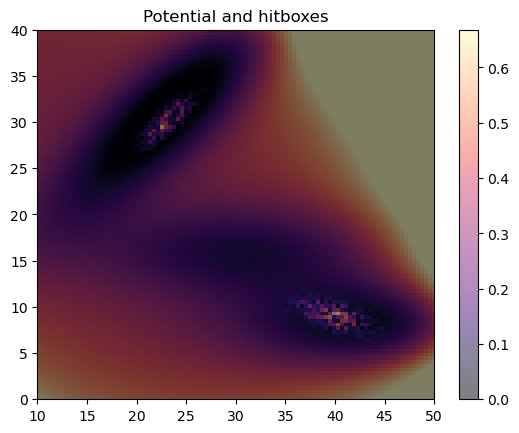

In [6]:
#Get initial descriptors and estimate variance in them. 
from simulator.cov_estimator import get_covariance

reactant_target = potential.initial_point
product_target = potential.final_point

react_var_inv, prod_var_inv = get_covariance(react_pos, prod_pos, reactant_target, product_target,
                                             coordinate_descriptors, domain, args, potential)



In [7]:
if args.bias == "gauss":
    height = 0.01
    resolution = 20
    var = 4**2
    sample_bias_force = GridGaussians(height, args.dimension, -10, 55, resolution, var=var, descriptors=coordinate_descriptors, device=args.device)
    if args.use_non_batched or args.no_adjoint:
        lr = 0.001/adjoint_multiplier
    else:
        lr = 50*args.learning_factor/adjoint_multiplier/args.batch_size  
        
if args.bias == "descriptor_basis":   
    
    height = 0.01
    resolution = 50
    var = 25/10
    sample_bias_force = BasisBias(height,args.dimension, -5, 55,
                                       resolution=resolution, var=var, neurons=args.neurons,
                                       descriptors=coordinate_descriptors, device=args.device)
    if args.use_non_batched or args.no_adjoint:
        lr = 0.1/adjoint_multiplier
    else:
        lr = args.learning_factor/adjoint_multiplier/args.batch_size    

if args.bias == "simple":   
    
    sample_bias_force = SimpleBias(args.dimension, neurons=args.neurons,
                                       descriptors=coordinate_descriptors, device=args.device)
    if args.use_non_batched or args.no_adjoint:
        lr = 0.1/adjoint_multiplier
    else:
        lr = args.learning_factor/adjoint_multiplier/args.batch_size/6  
else:
    raise RuntimeError("Undefined bias function")
    
sample_bias_force.to(args.device)
   
#Adam optimizer seems to work the best
optimizer = torch.optim.Adam(sample_bias_force.parameters(), lr=lr)

#Since we update scheduler only 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.3)

#Descriptors
descriptor_loss = DescriptorLoss(coordinate_descriptors, react_var_inv, prod_var_inv, args)

def sample_total_force(R):
       
    Epot, f_U = potential.force_func(R)   
    f_b = sample_bias_force.force_func(R)
    return f_U + f_b

def get_forces_vjp(R, vec):
    (_, vjpfunc) = vjp(sample_total_force, R)
    grad = vjpfunc(vec)[0]
    return grad


vmaped_force = vmap(sample_total_force)
vmaped_vjp = vmap(get_forces_vjp)

In [8]:
#Setup a logger
from torchmd.utils import LogWriter

logger = LogWriter(path=args.folder, keys=('iter','loss_fwd','loss_s','lr','success'), name='training.csv')

i = 0

Writing logs to  resultsMB/simpleD5p:0.05I:20001N150dt1.0T300g1.0verif/training.csv


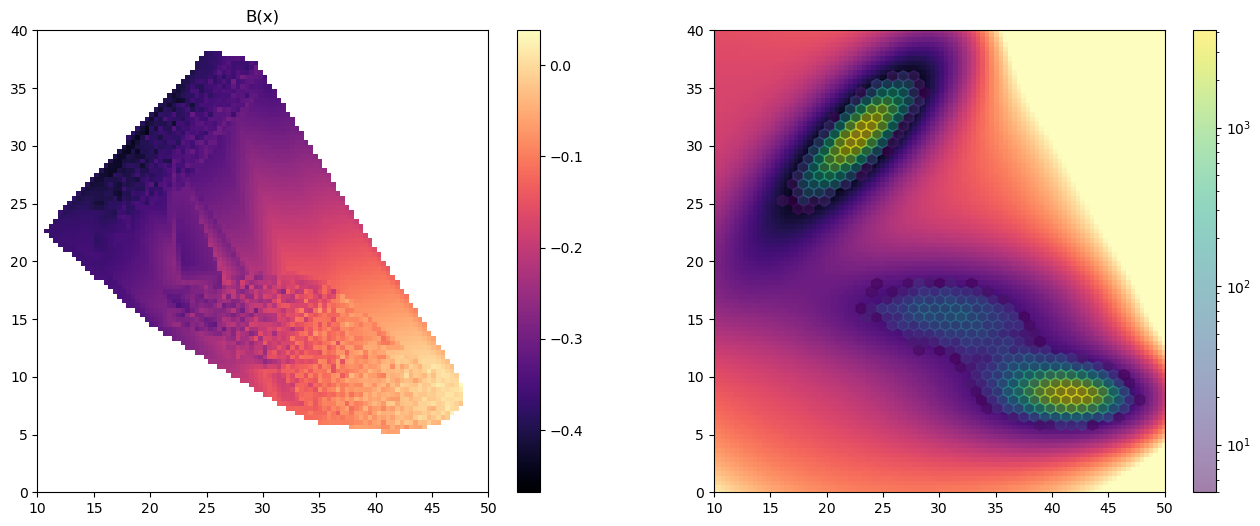

Iter:  1 l_f: 194596.9792 l_s: 0.0 lr:  3.333333333333333e-07 success:  0.01


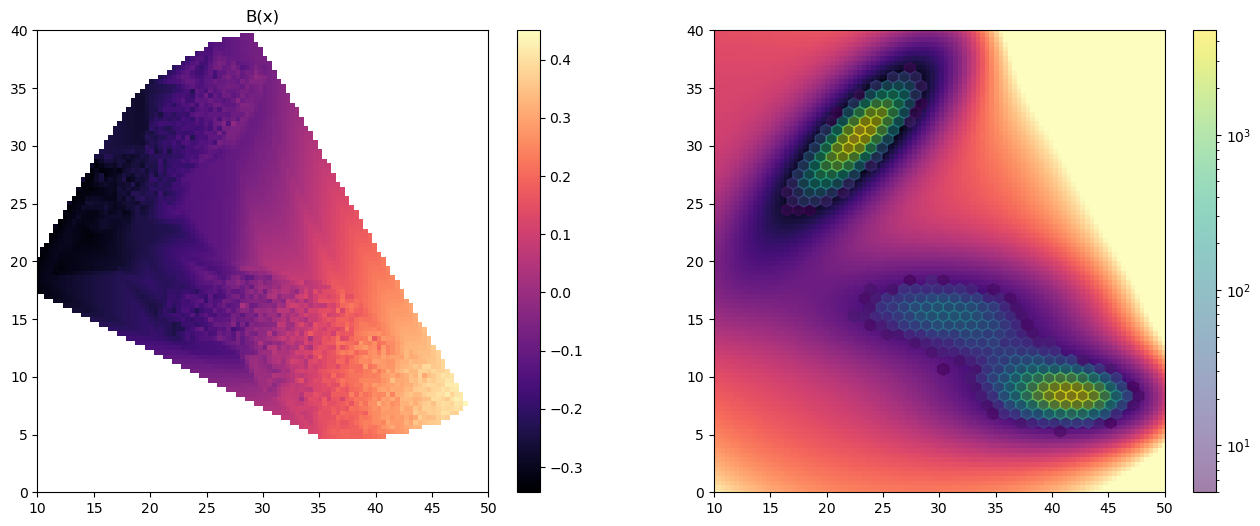

Iter:  2 l_f: 181909.7216 l_s: 0.0 lr:  3.333333333333333e-07 success:  0.018333333


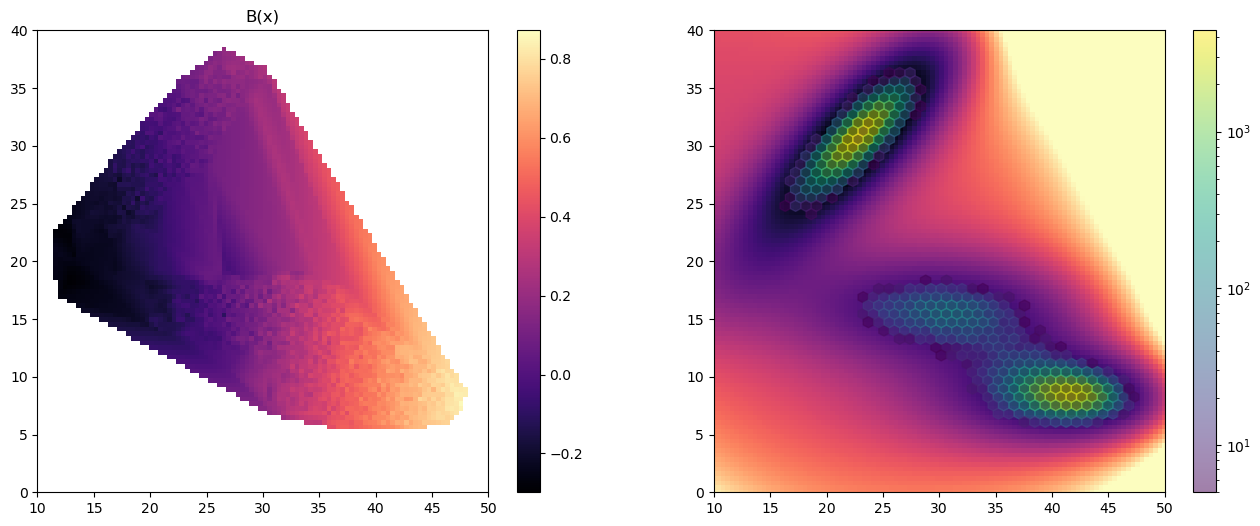

Iter:  3 l_f: 196208.576 l_s: 0.0 lr:  3.333333333333333e-07 success:  0.025


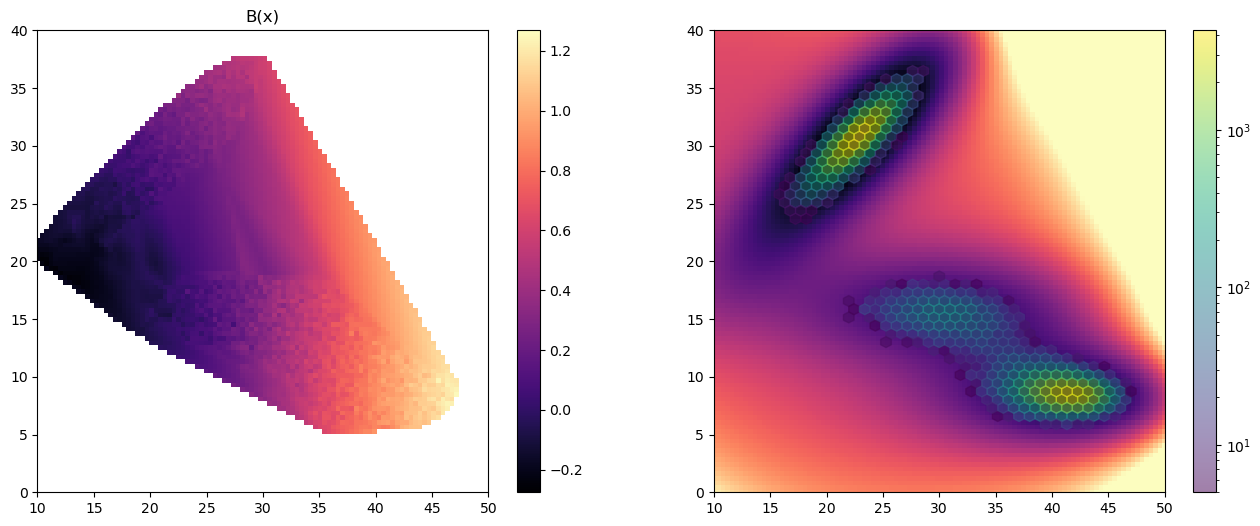

Iter:  4 l_f: 178316.7488 l_s: 0.0 lr:  3.333333333333333e-07 success:  0.043333333


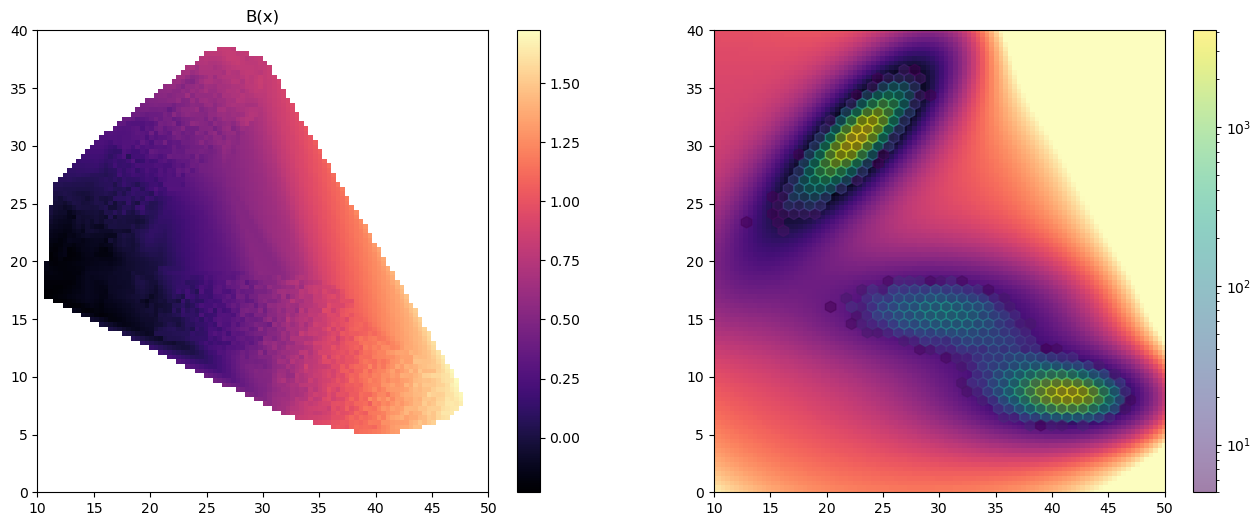

Iter:  5 l_f: 182332.1856 l_s: 33.00286875 lr:  3.333333333333333e-07 success:  0.07833333


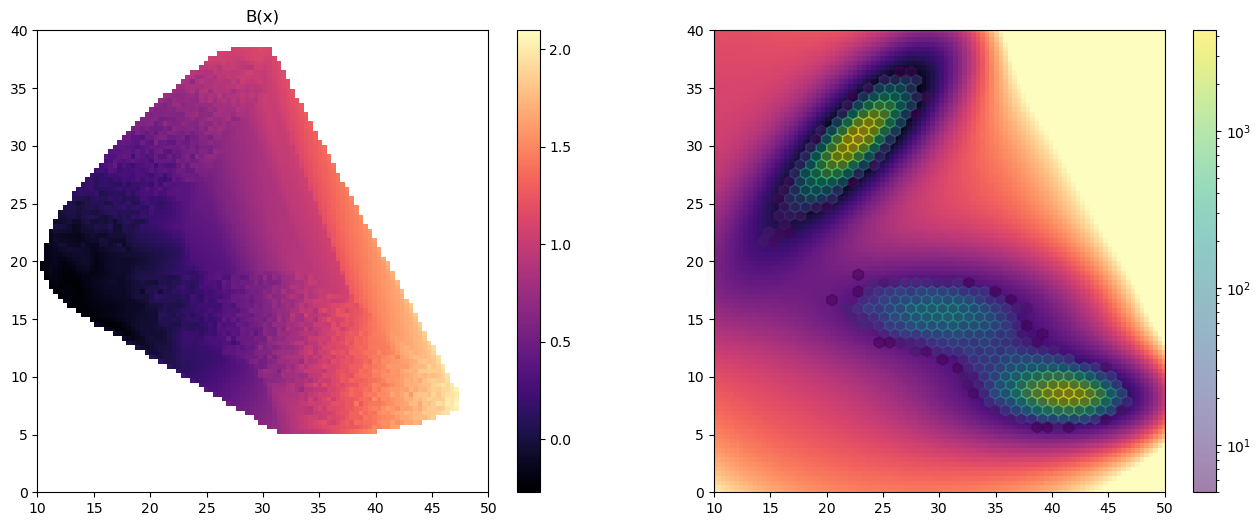

Iter:  6 l_f: 180716.9024 l_s: 0.0 lr:  3.333333333333333e-07 success:  0.07333333


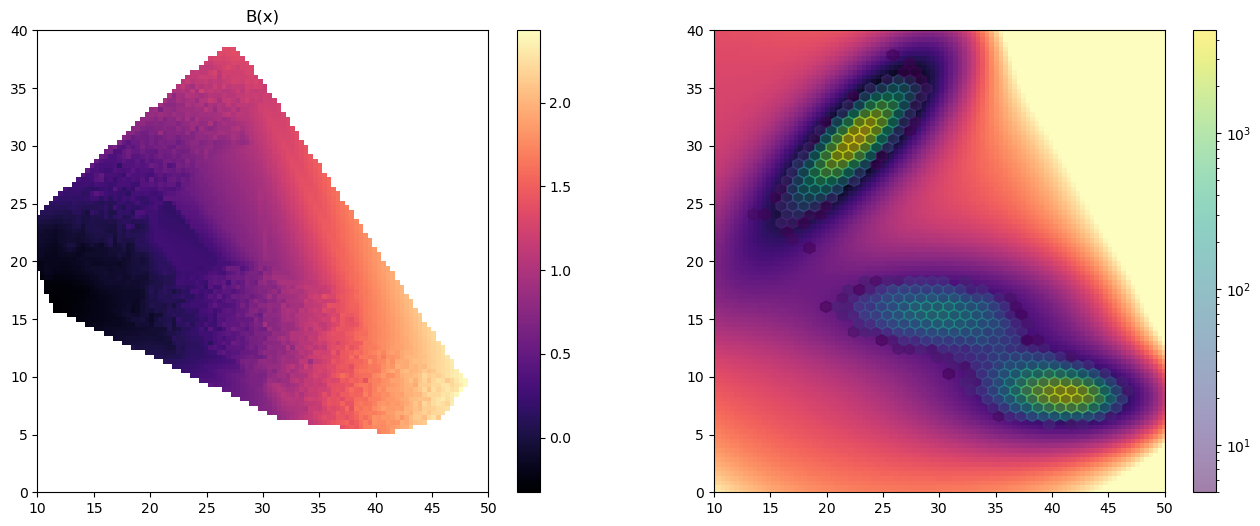

Iter:  7 l_f: 188450.9568 l_s: 0.0 lr:  3.333333333333333e-07 success:  0.105


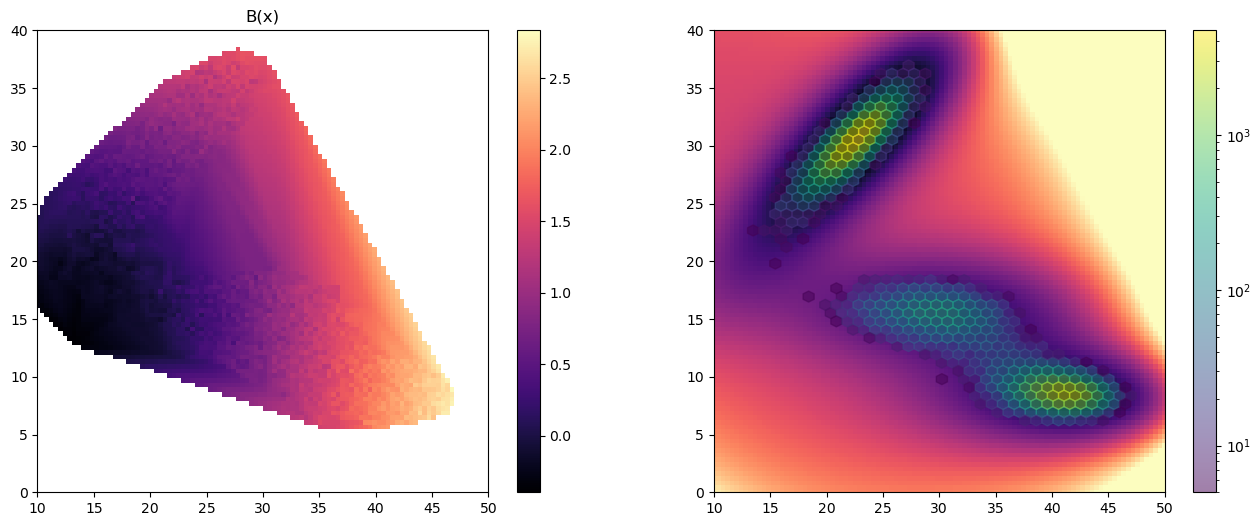

Iter:  8 l_f: 181833.7152 l_s: 0.0 lr:  3.333333333333333e-07 success:  0.15166667


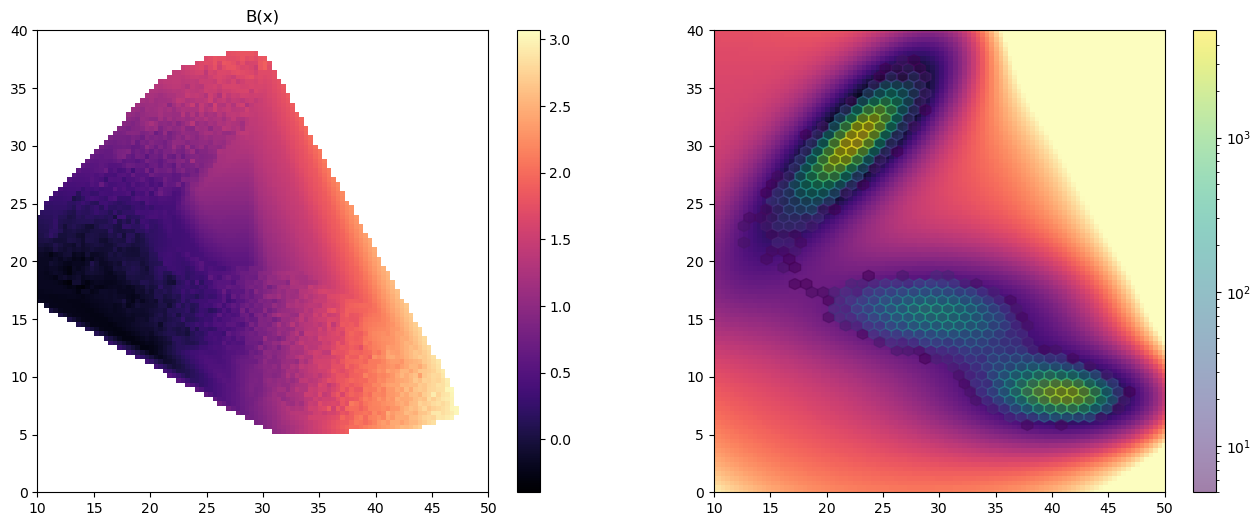

Iter:  9 l_f: 188598.1312 l_s: 747.2216 lr:  3.333333333333333e-07 success:  0.24166666


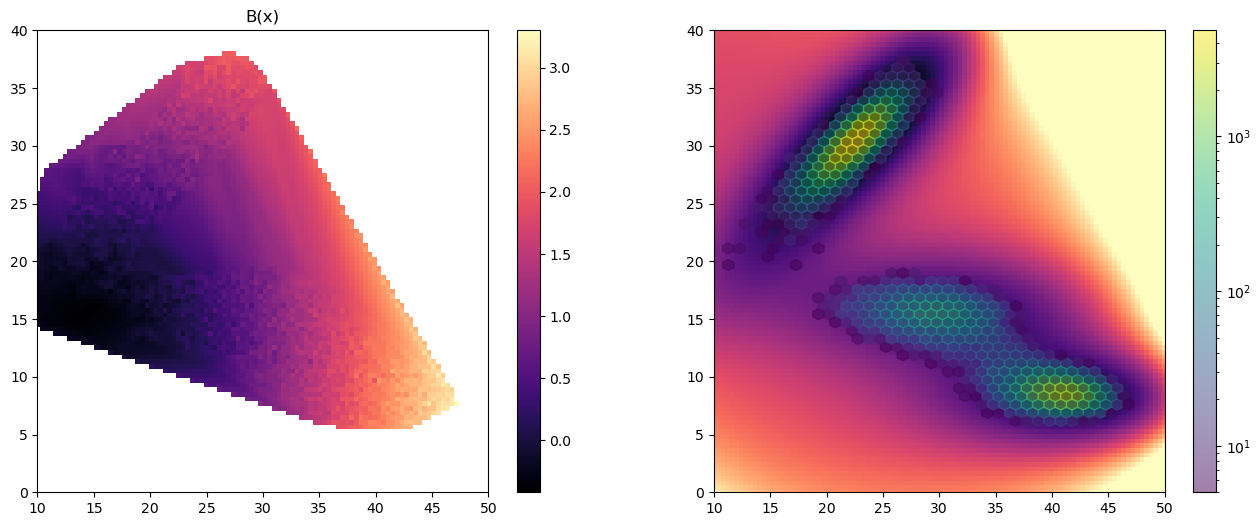

Iter:  10 l_f: 195664.6656 l_s: 703.51545 lr:  3.333333333333333e-07 success:  0.24


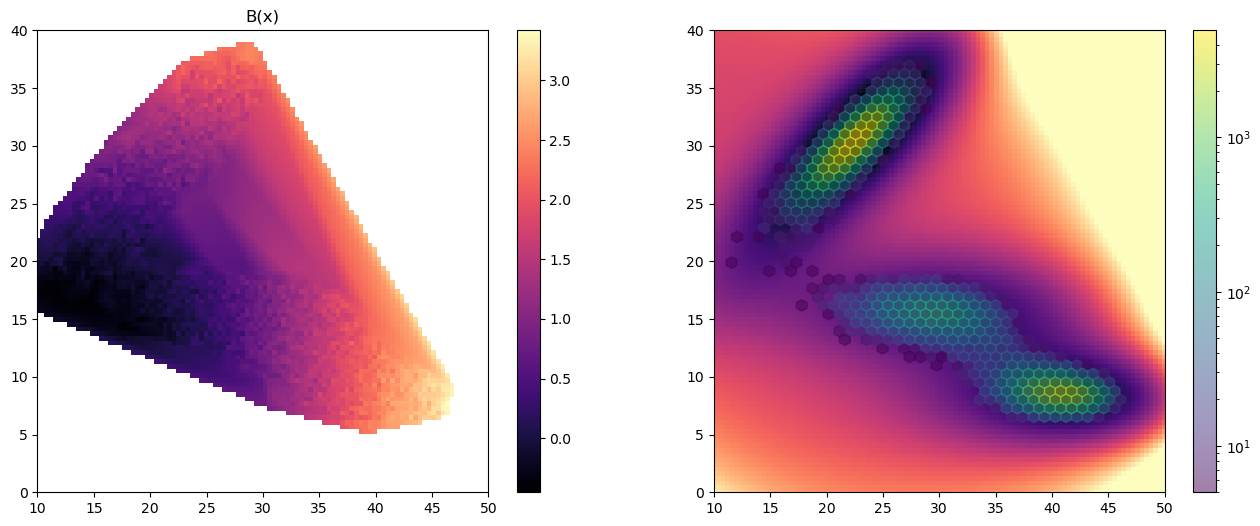

Iter:  11 l_f: 181215.4368 l_s: 689.1224 lr:  3.333333333333333e-07 success:  0.28333333


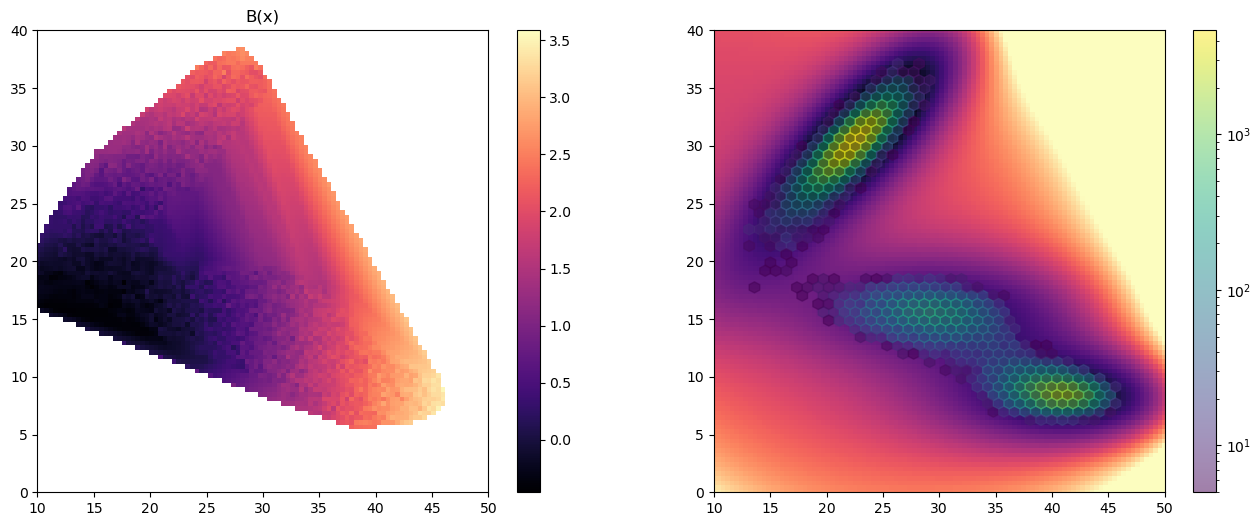

Iter:  12 l_f: 186750.3488 l_s: 1222.8542 lr:  3.333333333333333e-07 success:  0.29166666


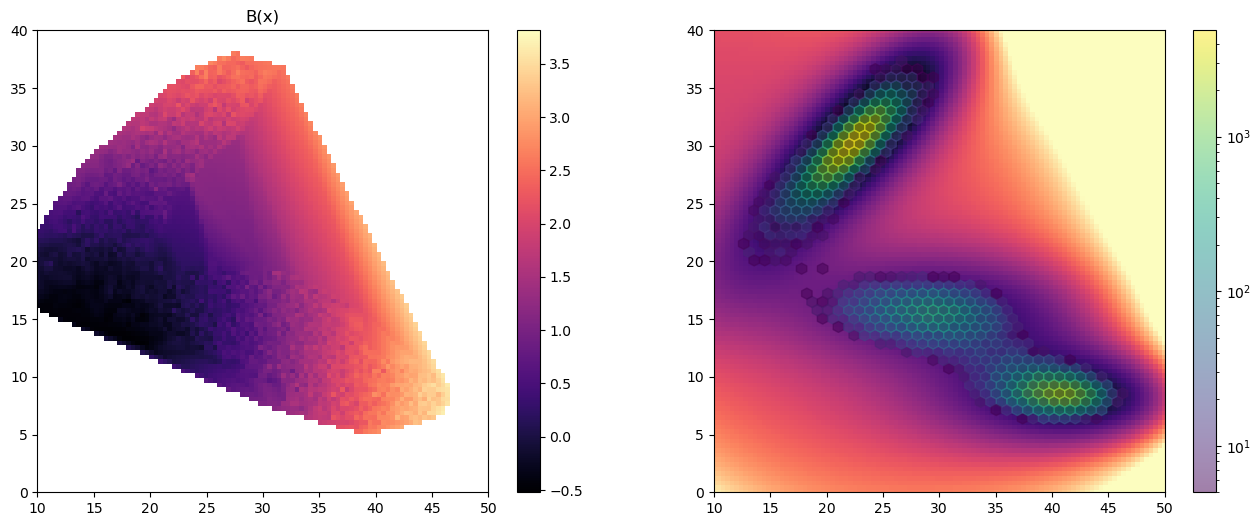

Iter:  13 l_f: 192208.9088 l_s: 2054.7554 lr:  3.333333333333333e-07 success:  0.3


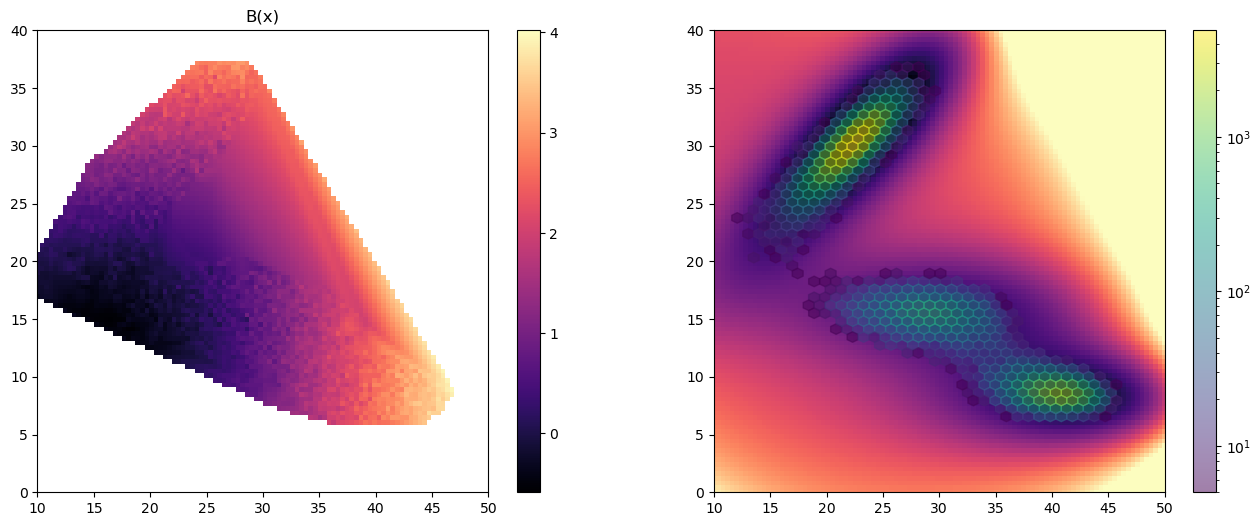

Iter:  14 l_f: 191060.7232 l_s: 3480.2428 lr:  3.333333333333333e-07 success:  0.33166668


In [ ]:
losses_forward, losses_start, lrs, successes = [], [], [], []

#sample_bias_force.load_state_dict(torch.load(args.folder+"modelGood.pt"))


with open(args.folder+'logs.txt', 'w') as f:
    while i < args.epochs+1:
        i = i+1
        #Get init and end point, running for a short time
        system, simulation_init, simulation_end = get_init_point()
        
        #Move to CPU for loss calculations For optimized version will stay on GPU
        simulation_init = simulation_init.cpu()
        simulation_end = simulation_end.cpu()

        #Run the main simulation loop
        trajectory, velocities_list, force_list = forward_simulate(system, vmaped_force, args)

        #Concated trajectory
        traj_tensor = torch.stack(trajectory, axis=1)
        traj_desc = coordinate_descriptors.get_descriptors(traj_tensor)        
        
        #Plot the quantities, like selected trajectories or PMF
        known_cvs = coordinate_descriptors.get_descriptors(traj_tensor)[...,project_to]


        if i % args.save_every_model == 0:
            plot_intermediate(traj_tensor, traj_desc, known_cvs, sample_bias_force, i, args, domain,potential)
            torch.save(sample_bias_force.state_dict(), args.folder+"model" + str(i) + ".pt")
        
        #Get losses
        #loss_forward, loss_start, forward_indices, 
        lf, ls, f_I, aN, s_I, aN_start, success_rate = descriptor_loss.dist_loss_adjoint(traj_tensor, simulation_end, simulation_init)

        #Scale to avoid  numerical errors
        loss_forward = lf*adjoint_multiplier
        loss_start = ls*adjoint_multiplier
        if aN is not None:
            aN = aN*adjoint_multiplier
            aN_start = aN_start*adjoint_multiplier
        
        #Print some statistics
        stats = {}
        stats["iter"] = i
        stats["loss_fwd"] = loss_forward.detach().cpu().numpy()/adjoint_multiplier
        stats["loss_s"] = loss_start.detach().cpu().numpy()/adjoint_multiplier
        stats["lr"] = scheduler.get_last_lr()[0]
        stats["success"] = success_rate.cpu().numpy()
        
        logger.write_row(stats)
        print("Iter: ", i, "l_f:", stats["loss_fwd"], "l_s:", stats["loss_s"], "lr: ", stats["lr"], "success: ", stats["success"], flush=True)
        
        
        losses_forward.append(loss_forward.detach().cpu().numpy())
        losses_start.append(loss_start.detach().cpu().numpy())
        lrs.append(scheduler.get_last_lr()[0])
        successes.append(success_rate.detach().cpu().numpy())  
        
        #Learning rate scheduling based on success rate
        if success_rate >= first_thr and not first_checkpoint:
            first_checkpoint = True
            scheduler.step()
        if success_rate > second_thr and not second_checkpoint:
            second_checkpoint = True
            scheduler.step()

            
        if args.no_adjoint:
            #Differentiate trajectory and get adjoits by full backprop. Used for testing
            intermediate_grads = torch.autograd.grad(loss_forward, force_list, retain_graph=True, create_graph=False, allow_unused=True)
            intermediate_grads_start = torch.autograd.grad(loss_start, force_list, retain_graph=False, allow_unused=True)
            adjoints = torch.stack(intermediate_grads + intermediate_grads_start, dim=1)
            
            R_tensor = traj_tensor[:,:-1].detach().repeat(1,2,1,1)
            adjoints = adjoints.reshape(-1, *adjoints.shape[2:])
            R_tensor = R_tensor.reshape(-1, *adjoints.shape[2:])
  
            train_epoch(adjoints, R_tensor, bias_force, optimizer, n_in, args)

        else:
            #Use adjoint method to get adjoints. Memmory efficient.
            adjoints_forward, testR = get_adjoints(system, aN, traj_tensor, f_I, vmaped_vjp, system.M, args)
            adjoints_start, testR_start = get_adjoints(system, aN_start, traj_tensor, s_I, vmaped_vjp, system.M, args)


            adjoints = torch.cat((adjoints_forward.reshape(-1, *adjoints_forward.shape[2:]), adjoints_start.reshape(-1, *adjoints_start.shape[2:])))
            R_tensor = torch.cat((testR.reshape(-1,*testR.shape[2:]), testR_start.reshape(-1,*testR_start.shape[2:])))

            adjoints_filter = (adjoints.abs().sum((-1))>1e-8)
            adjoints = adjoints[adjoints_filter]
            R_tensor = R_tensor[adjoints_filter]
            
            train_epoch(adjoints, R_tensor, sample_bias_force, optimizer, args.dimension, args)



   

In [ ]:
#sample_bias_force.load_state_dict(torch.load(args.folder+"model65.pt"))

trajectory, velocities_list, force_list = forward_simulate(system, vmaped_force, args)


In [ ]:
traj_tensor = torch.stack(trajectory, axis=1)
    
output_tensor = traj_tensor.reshape(-1,args.dimension)
output_tensor = output_tensor[::10,:]
print(output_tensor[::10,:].shape)
columns = ["x" + str(i+1) for i in range(output_tensor.shape[1])]
df = pd.DataFrame(output_tensor.detach().numpy(), columns=columns)
df["potential"] = potential.U(output_tensor.to(args.device)).detach().cpu()
df["bias"] = sample_bias_force.bias(output_tensor.to(args.device)).detach().cpu()

df.to_csv(args.folder+"converged_results.csv")